# Ekstraksi Fitur Warna dan GLCM

import library yang akan digunakan

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Siapkan file gamabr yang akan diolah, kemudian resize gambar agar proses lebih ringan.

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Pengolahan_Citra/Daun Sehat/IMG_20220903_103536_1.jpg')
image = cv2.resize(image,(300,300))

Konveri RGB ==> CMYK

In [ ]:
img = image.astype(np.float64)/255.
K = 1 - np.max(img, axis=2)
C = (1-img[...,2] - K)/(1-K) #(1-R-K)/(1-k)
M = (1-img[...,1] - K)/(1-K) # (1-G-K)/(1-k)
Y = (1-img[...,0] - K)/(1-K) #(1-B-K)/(1-k)
CMYK_image= (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)

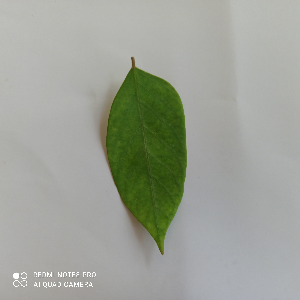

In [ ]:
cv2_imshow(image)

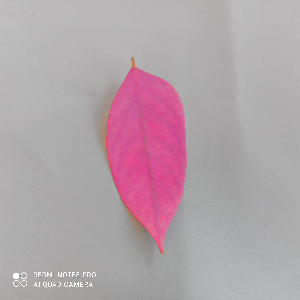

In [ ]:
cv2_imshow(CMYK_image)

Konveri RGB ==> ycbcr


In [ ]:
cbcr = np.empty_like(image) #membuat array unitialized yang ukurannya sama dengan image

r = image[:,:,2]
g = image[:,:,1]
b = image[:,:,0]

# Y
cbcr[:,:,0] = .299 * r + .587 * g + .114 * b
# Cb
cbcr[:,:,1] = 128 - .169 * r - .331 * g + .5 * b
# Cr
cbcr[:,:,2] = 128 + .5 * r - .419 * g - .081 * b

hasil_ycbcr= np.uint8(cbcr)

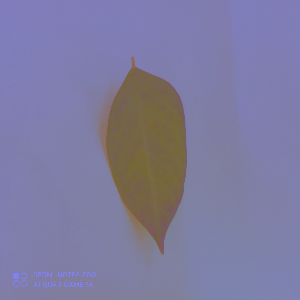

In [ ]:
cv2_imshow(hasil_ycbcr)

Fuction Konversi RGB ==> BGR

In [ ]:
def rgb(image_file,x,y):
  global B
  global G
  global R
  B,G,R = image_file[x,y]
  return B,G,R

Fuction Konversi RGB ==> CMYK

In [ ]:
def cmyk(image_file,x,y):
  global C
  global M
  global Y
  global K
  img = image_file.astype(np.float64)/255.
  K = 1 - np.max(img, axis=2)
  C = (1-img[...,2] - K)/(1-K) #(1-R-K)/(1-k)
  M = (1-img[...,1] - K)/(1-K) # (1-G-K)/(1-k)
  Y = (1-img[...,0] - K)/(1-K) #(1-B-K)/(1-k)

  CMYK_image= (np.dstack((C,M,Y,K)) * 255).astype(np.uint8)
  C,M,Y,K = CMYK_image[x,y]
  return C,M,Y,K

Fuction Konversi RGB ==> YCbCr

In [ ]:
def ycbcr(image_file,x,y):
  global Y
  global Cb
  global Cr

  cbcr = np.empty_like(image_file) #membuat array unitialized yang ukurannya sama dengan image

  r = image_file[:,:,0]
  g = image_file[:,:,1]
  b = image_file[:,:,2]
  
  # Y
  cbcr[:,:,0] = .299 * r + .587 * g + .114 * b
  # Cb
  cbcr[:,:,1] = 128 - .169 * r - .331 * g + .5 * b
  # Cr
  cbcr[:,:,2] = 128 + .5 * r - .419 * g - .081 * b

  ycbcr_image= np.uint8(cbcr)
  Y,Cb,Cr = ycbcr_image[x,y]
  return Y,Cb,Cr

Function GLCM

In [ ]:
from skimage.feature import greycomatrix, greycoprops
def calc_glcm_all_agls(img,props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    # feature.append(label) 
    
    return feature

Data 1000 citra yang akan diolah

In [ ]:
images_path = glob.glob('/content/drive/MyDrive/Pengolahan_Citra/*.jpg')

In [ ]:
imgs = [] #list image matrix 
# labels = []
# descs = []

for image in images_path:
    img = cv2.imread(image)   
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    h, w = gray.shape
    ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
    crop = gray[ymin:ymax, xmin:xmax]       
    resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)
            
    imgs.append(resize)
    # labels.append(normalize_label(os.path.splitext(filename)[0]))
    # descs.append(normalize_desc(folder, sub_folder))
            
            # print_progress(i, len_sub_folder, folder, sub_folder, filename)

In [ ]:
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_all_agls = []
for img in imgs: 
    glcm_all_agls.append(
            calc_glcm_all_agls(img,   
                                props=properties)
                            )
 
columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)

In [ ]:
import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(glcm_all_agls, 
                      columns = columns)

glcm_df.head(5)

,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,...,contrast_90,contrast_135,ASM_0,ASM_45,ASM_90,ASM_135,energy_0,energy_45,energy_90,energy_135
0,1.997763,2.194891,1.808297,1.776773,0.990949,0.986506,0.992701,0.994676,0.522625,0.518820,...,16.403344,11.964829,0.008983,0.008874,0.009268,0.009112,0.094776,0.094202,0.096268,0.095455
1,2.626080,3.662115,3.796002,3.373602,0.989787,0.968802,0.969215,0.981664,0.381453,0.340519,...,61.290932,36.522342,0.002427,0.002209,0.002164,0.002161,0.049264,0.047000,0.046522,0.046484
2,1.693095,2.059000,1.850130,1.662637,0.992050,0.982639,0.986879,0.993240,0.547220,0.539432,...,24.892202,12.846104,0.012568,0.012506,0.012782,0.012475,0.112106,0.111828,0.113057,0.111693
3,2.913229,3.845160,3.841522,3.662610,0.984392,0.960353,0.959781,0.971291,0.348564,0.301426,...,57.913890,41.368203,0.001753,0.001558,0.001578,0.001525,0.041863,0.039477,0.039723,0.039053
4,3.374614,2.508732,2.612106,3.754544,0.980451,0.991017,0.990094,0.976024,0.353225,0.402314,...,18.894473,45.508341,0.002670,0.002878,0.002962,0.002550,0.051676,0.053650,0.054429,0.050500


In [ ]:
%cd /content/drive/MyDrive/Pengolahan_Citra

/content/drive/MyDrive/Pengolahan_Citra


In [ ]:
# determining the name of the file
file_name = 'GLCM.xlsx'
  
# saving the excel
glcm_df.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')

DataFrame is written to Excel File successfully.


In [ ]:
writer = pd.ExcelWriter('Hasil_warna.xlsx')

In [ ]:
#1000 image

index = 0
img_ke = 1
tabel_hasil = []
kolom = ["Image","R", "G", "B", "C", "M","Y","K", "Y", "Cb", "Cr"]
tabel_hasil.append(kolom)
for image in images_path:
  image = cv2.imread(image)
  image = cv2.resize(image,(200,300))
  rgb(image,100,100)
  cmyk(image,100,100)
  ycbcr(image,100,100)
  tabel_baris = [
      img_ke,
      R,
      G,
      B,
      C,
      M,
      Y,
      K,
      Y,
      Cb,
      Cr

      
  ]
  index+=1
  img_ke+=1
  tabel_hasil.append(tabel_baris)

tabel_hasil = pd.DataFrame(tabel_hasil)
tabel_hasil.to_excel(writer, sheet_name="RGB-CMYK")
writer.save()